# Introduction

<div class="alert alert-block alert-danger">
<b>

THIS NOTEBOOK IS A STUB, CODE IS INCOMPLETE

</b>
</div>

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# CelebA Dataset

In [4]:
dataset_location = '/home/marcin/Datasets/img_align_celeba'

In [5]:
datafile = os.path.join(dataset_location, 'img_align_celeba_32x32.npz')
print(datafile)

/home/marcin/Datasets/img_align_celeba/img_align_celeba_32x32.npz


In [6]:
import PIL

In [7]:
all_files = os.listdir(os.path.join(dataset_location, 'img_align_celeba'))

In [8]:
def crop_celeba(img, size):
    assert img.size == (178, 218)
    box = [25, 65, img.width-25, img.height-25]  # crop 25/65/25/25 from left/top/right/bottom
    return img.crop(box)                         # result.size = (128, 128)

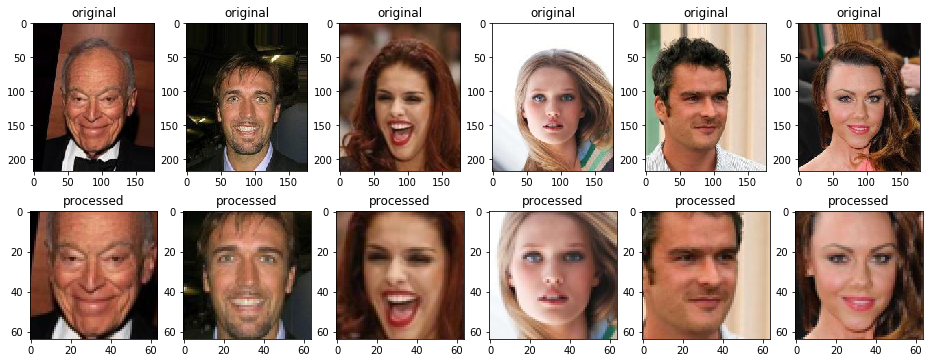

In [9]:
fig, (axes1, axes2) = plt.subplots(nrows=2, ncols=6, figsize=[16,6])
for i in range(len(axes1)):
    idx = np.random.randint(0, len(all_files))
    img_full_path = os.path.join(dataset_location, 'img_align_celeba', all_files[idx])
    img = PIL.Image.open(img_full_path)
    img_128x128 = crop_celeba(img, None)
    img_64x64 = img_128x128.resize([64, 64], PIL.Image.BICUBIC)
    axes1[i].imshow(img)
    axes1[i].set_title('original')
    axes2[i].imshow(img_64x64)
    axes2[i].set_title('processed')

In [10]:
def load_all_images(dataset_location, all_files, size=32):
    all_images = []
    for i in range(len(all_files)):
        img_full_path = os.path.join(dataset_location, 'img_align_celeba', all_files[i])
        img = PIL.Image.open(img_full_path)
        img_128x128 = crop_celeba(img, None)
        img_small = img_128x128.resize([size, size], PIL.Image.BICUBIC)  
        arr = np.array(img_small)
        assert arr.shape == (size, size, 3)
        all_images.append(arr)
        if i % 10000 == 0:
            print(f'Image {i} of {len(all_files)}')
    return np.array(all_images)

In [11]:
# if not os.path.isfile(datafile):
#     print('Creating datafile...')
#     all_images = load_all_images(dataset_location, all_files, size=32)
#     np.savez(datafile, all_images=all_images)
# else:
#     print('Loading from file...')
#     npzfile = np.load(datafile)
#     all_images = npzfile['all_images']

In [12]:
# x_train = (all_images.astype(np.float32) / 127.5) - 1      # scale to range [-1..1]
# x_train = x_train[:-103]                                   # make divisible by 128
# x_train.shape

In [13]:
# del all_images  # save memory

# SVHN Dataset

In [4]:
import torch
from torchvision import datasets
from torchvision import transforms

In [5]:
dataset = datasets.SVHN(root='~/.pytorch/svhn/', split='train', download=True, transform=None)

Using downloaded and verified file: /home/marcin/.pytorch/svhn/train_32x32.mat


In [6]:
x_train = (dataset.data.astype(np.float32) / 127.5) - 1   # scale to range [-1..1]
x_train = x_train[:-41]  # make divisible by 512
print(x_train.shape)

(73216, 3, 32, 32)


Visualize the data

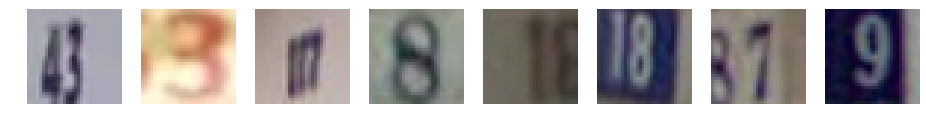

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=[16,6])
for i in range(len(axes)):
    idx = np.random.randint(0, len(x_train))
    img = x_train[idx]
    img = img/2 + .5         # -1..1 -> 0..1
    img = img.transpose(1, 2, 0)
    axes[i].imshow(img); axes[i].axis('off')

Move to GPU if available

In [8]:
x_train = torch.tensor(x_train, device=device)

# DCGAN in PyTorch

Discriminator

In [9]:
class Discriminator(nn.Module):
    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        self.L1_conv = nn.Conv2d(3, conv_dim, kernel_size=4, stride=2, padding=1, bias=False)
        self.L1_act = nn.LeakyReLU(0.2)

        self.L2_conv = nn.Conv2d(conv_dim, 2*conv_dim, kernel_size=4, stride=2, padding=1, bias=False)
        self.L2_bn = nn.BatchNorm2d(2*conv_dim)
        self.L2_act = nn.LeakyReLU(0.2)
        
        self.L3_conv = nn.Conv2d(2*conv_dim, 4*conv_dim, kernel_size=4, stride=2, padding=1, bias=False)
        self.L3_bn = nn.BatchNorm2d(4*conv_dim)
        self.L3_act = nn.LeakyReLU(0.2)
        
        self.L4_fc = nn.Linear(in_features=4*conv_dim*4*4, out_features=1)

    def forward(self, x):
        x = self.L1_conv(x)
        x = self.L1_act(x)
        
        x = self.L2_conv(x)
        x = self.L2_bn(x)
        x = self.L2_act(x)
        
        x = self.L3_conv(x)
        x = self.L3_bn(x)
        x = self.L3_act(x)
       
        x = x.view(x.size(0), -1) # flatten
        x = self.L4_fc(x)
        return x

Generator

In [10]:
class Generator(nn.Module):
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        
        self.L0_fc = nn.Linear(in_features=z_size, out_features=4*conv_dim*4*4)
        
        self.L1_convT = nn.ConvTranspose2d(4*conv_dim, 2*conv_dim, kernel_size=4, stride=2, padding=1, bias=False)
        self.L1_bn = nn.BatchNorm2d(2*conv_dim)
        self.L1_act = nn.ReLU()
        
        self.L2_convT = nn.ConvTranspose2d(2*conv_dim, conv_dim, kernel_size=4, stride=2, padding=1, bias=False)
        self.L2_bn = nn.BatchNorm2d(conv_dim)
        self.L2_act = nn.ReLU()
               
        self.L3_convT = nn.ConvTranspose2d(conv_dim, 3, kernel_size=4, stride=2, padding=1, bias=False)
        self.L3_act = nn.Tanh()
        
    def forward(self, x):
        x = self.L0_fc(x)
        x = x.view(x.size(0), 4*self.conv_dim, 4, 4)
        
        x = self.L1_convT(x)
        x = self.L1_bn(x)
        x = self.L1_act(x)
        
        x = self.L2_convT(x)
        x = self.L2_bn(x)
        x = self.L2_act(x)
        
        x = self.L3_convT(x)
        x = self.L3_act(x)
        return x

DCGAN Model

In [11]:
conv_dim = 32
z_size = 100

generator = Generator(z_size=z_size, conv_dim=conv_dim)
discriminator = Discriminator(conv_dim)

generator.to(device)
discriminator.to(device)

criterion = nn.BCEWithLogitsLoss()

lr, betas = 0.0002, (0.5, 0.999)
d_optimizer = optim.Adam(discriminator.parameters(), lr, betas)
g_optimizer = optim.Adam(generator.parameters(), lr, betas)

Helpers

In [12]:
def plot_images(x_fake):  # Expects tensor shape [batch, 3, width, height]
    fig, axes = plt.subplots(nrows=1, ncols=10, figsize=[16,9])
    for i, ax in enumerate(axes):
        img = x_fake[i].detach().cpu().permute(1, 2, 0).numpy()
        ax.imshow(img/2+.5)
        ax.axis('off')
    plt.show()
    
def plot_loss(losses):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.plot(losses['disc'], label='disc')
    ax.plot(losses['gen'], label='gen')
    plt.show()

Train Model

In [13]:
n_batch = 128
n_epochs = 1

fixed_noise = torch.rand(16, z_size, device=device)*2-1   # uniform -1..1

In [ ]:
losses = {'gen':[], 'disc':[]}
indices = np.array(range(len(x_train)))

iteration = 0
for e in range(n_epochs):
    
    time_start = time.time()
    
    np.random.shuffle(indices)
    for i in range(0, len(x_train), n_batch):
        
        # Pick next batch of real images
        i_batch = indices[i:i+n_batch]
        x_real = x_train[i_batch]
        
        # Generate fake images
        noise = torch.rand(len(x_real), z_size, device=device)*2-1  # uniform -1..1
        x_fake = generator(noise)
        
        
        # Train the discriminator
        d_optimizer.zero_grad()
        
        outputs_real = discriminator(x_real)  # logits
        y_real = torch.ones(len(x_real), 1, device=device) * .9
        d_real_loss = criterion(outputs_real, y_real)
        
        outputs_fake = discriminator(x_fake)  # logits
        y_fake = torch.zeros(len(x_fake), 1, device=device)
        d_fake_loss = criterion(outputs_fake, y_fake)
        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # Train the generator
        g_optimizer.zero_grad()
        
        noise = torch.rand(len(x_real), z_size, device=device)*2-1  # uniform -1..1
        x_fake = generator(noise)
        y_fake = torch.ones(len(x_real), 1, device=device)   # flip labels
        outputs_fake = discriminator(x_fake)
        
        g_loss = criterion(outputs_fake, y_fake)
        g_loss.backward()
        g_optimizer.step()
        
        losses['disc'].append(d_loss.item())
        losses['gen'].append(g_loss.item())
        
        # Print some loss stats
        if iteration % 100 == 0:
            
            # print discriminator and generator loss
            time_epoch = time.time() - time_start
            print(f'epoch {time_epoch:2f}s: {e:3}     gloss: {g_loss:4.2f}     dloss: {d_loss:4.2f}')
            plot_images(x_fake)
            
        iteration += 1

    
    ## AFTER EACH EPOCH##    
    generator.eval() # for generating samples
    samples_z = generator(fixed_noise)
    generator.train() # back to training mode
    
    time_epoch = time.time() - time_start
    print(f'epoch {time_epoch:2f}s: {e:3}     gloss: {g_loss:4.2f}     dloss: {d_loss:4.2f}')
    plot_images(samples_z)
    plot_loss(losses)




In [ ]:
raise

epoch 0.028862s:   0     gloss: 0.80     dloss: 1.40


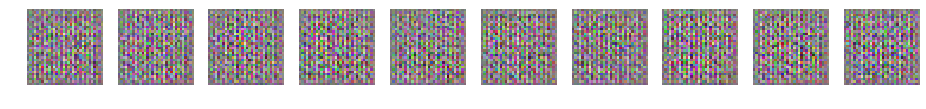

epoch 1.862700s:   0     gloss: 3.43     dloss: 0.45


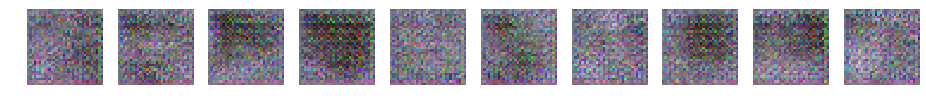

epoch 3.641867s:   0     gloss: 3.05     dloss: 0.56


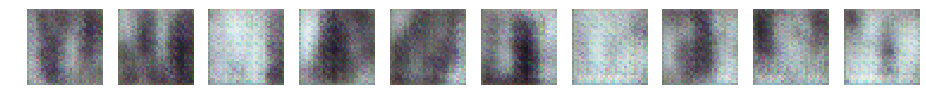

epoch 5.422685s:   0     gloss: 1.36     dloss: 0.89


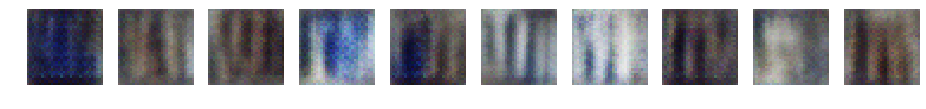

epoch 7.312775s:   0     gloss: 2.62     dloss: 0.61


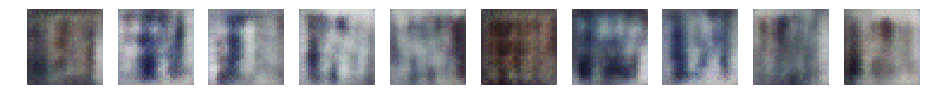

epoch 9.104053s:   0     gloss: 1.71     dloss: 0.97


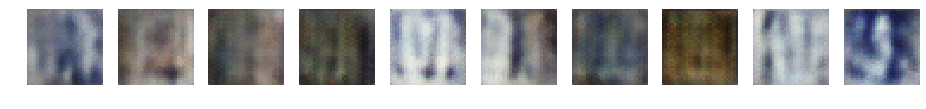

epoch 10.486014s:   0     gloss: 1.39     dloss: 1.02


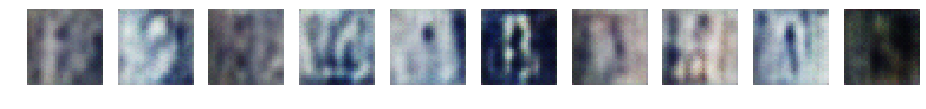

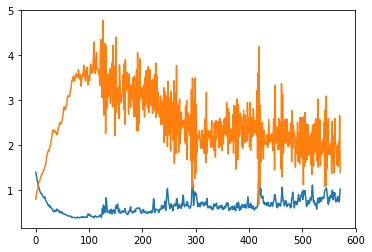

In [14]:
##

In [ ]:
raise

Epoch [    0/    5] | d_loss: 1.4218 | g_loss: 0.7516


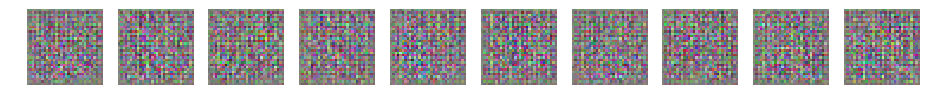

Epoch [    0/    5] | d_loss: 0.9479 | g_loss: 2.7296


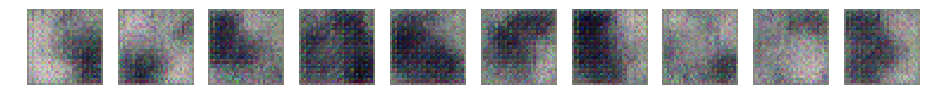

Epoch [    0/    5] | d_loss: 0.3336 | g_loss: 3.7614


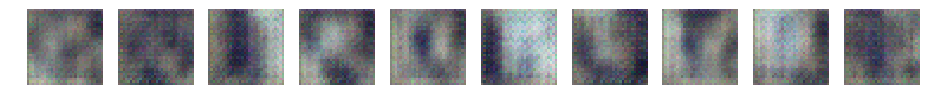

Epoch [    0/    5] | d_loss: 0.3578 | g_loss: 2.5790


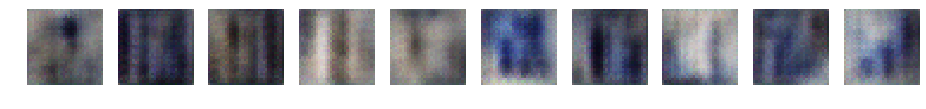

Epoch [    0/    5] | d_loss: 0.5091 | g_loss: 2.5414


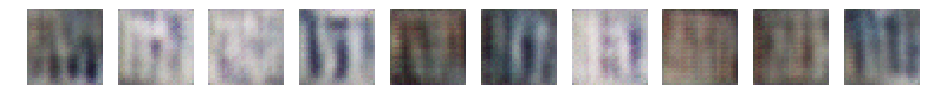

Epoch [    0/    5] | d_loss: 0.7015 | g_loss: 1.4707


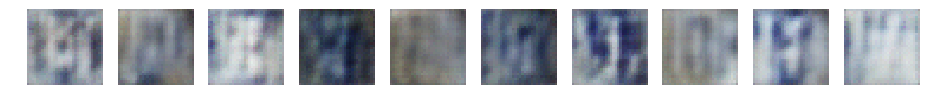

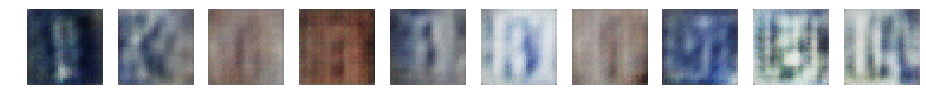

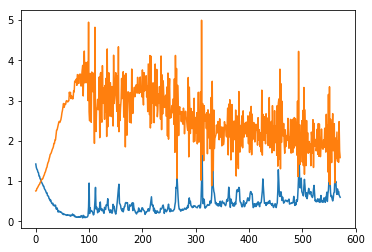

Epoch [    1/    5] | d_loss: 0.5047 | g_loss: 2.2709


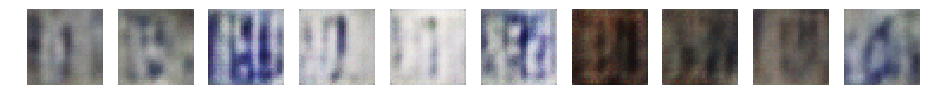

Epoch [    1/    5] | d_loss: 0.7572 | g_loss: 3.2401


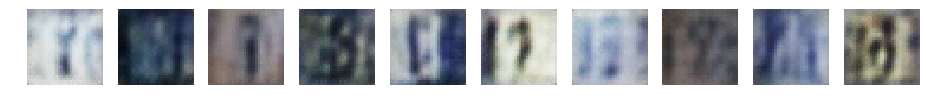

Epoch [    1/    5] | d_loss: 0.5608 | g_loss: 2.4933


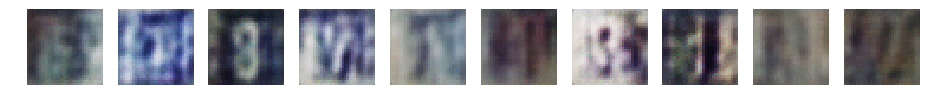

Epoch [    1/    5] | d_loss: 0.8241 | g_loss: 1.4939


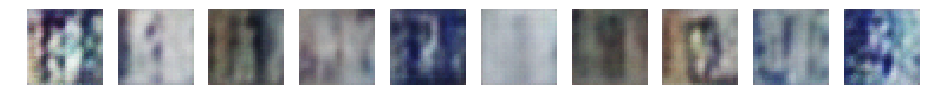

Epoch [    1/    5] | d_loss: 0.7458 | g_loss: 1.5815


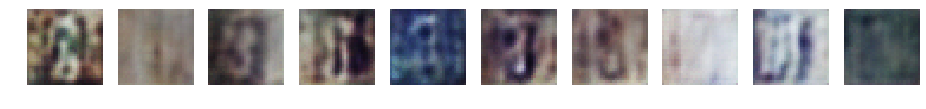

Epoch [    1/    5] | d_loss: 0.7095 | g_loss: 1.5951


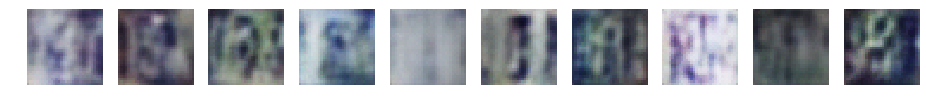

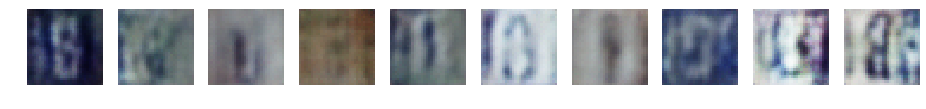

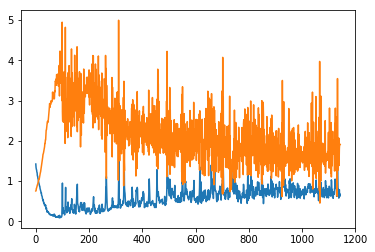

Epoch [    2/    5] | d_loss: 0.7527 | g_loss: 2.8969


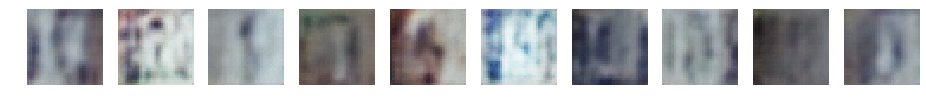

Epoch [    2/    5] | d_loss: 0.8178 | g_loss: 2.4077


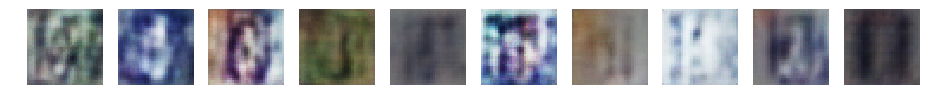

Epoch [    2/    5] | d_loss: 0.6996 | g_loss: 1.7120


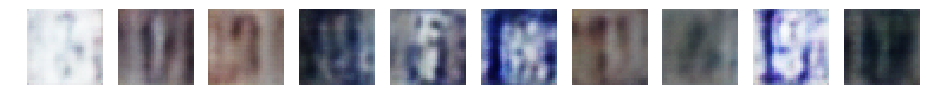

Epoch [    2/    5] | d_loss: 0.6037 | g_loss: 1.6258


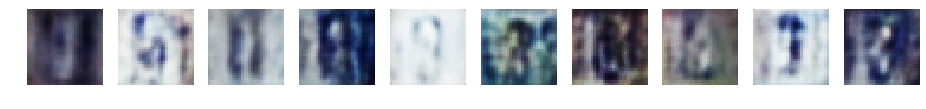

Epoch [    2/    5] | d_loss: 0.6059 | g_loss: 2.3164


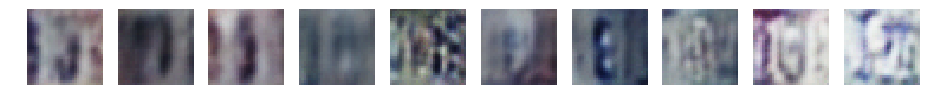

Epoch [    2/    5] | d_loss: 0.5326 | g_loss: 2.0559


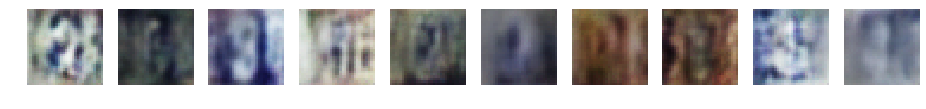

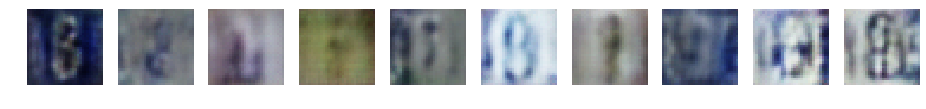

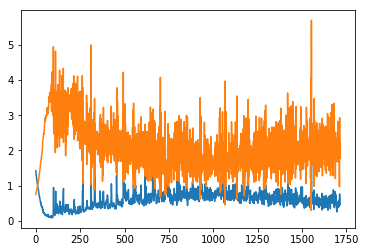

Epoch [    3/    5] | d_loss: 0.5025 | g_loss: 2.3540


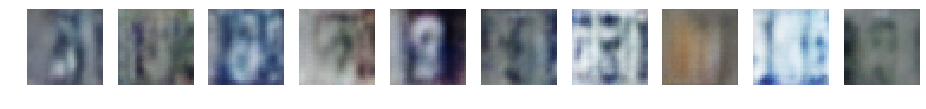

KeyboardInterrupt: 

In [38]:
##